In [1]:
from google.colab import drive
drive.mount ('/content/drive')

import sys
%cd /content/drive/My\ Drive/Colab\ Notebooks/A-Sliced-Wasserstein-Loss-for-Neural-Texture-Synthesis
sys.path.append('/content/drive/My Drive/Colab Notebooks/A-Sliced-Wasserstein-Loss-for-Neural-Texture-Synthesis')

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/A-Sliced-Wasserstein-Loss-for-Neural-Texture-Synthesis


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
import numpy as np
import os
import decoders
from helpers import initialize_image, gram_matrix, gram_loss, slice_loss

In [3]:
SIZE = 256
INPUT_FILE = "./input.jpg"
OUTPUT_FILE = "./output.jpg"
NB_ITER = 5

## Custom VGG model with Slicing model using user defined tags

In [10]:

def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # A customized vgg is used as explained in the supplementals.
  vgg = keras.models.load_model('vgg_customized.h5')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

class Slicing_with_tag(tf.keras.layers.Layer):
    """ Slicing layer: computes projections and returns sorted vector """
    def __init__(self, num_slices):
        super().__init__()
        # Number of directions
        self.num_slices = num_slices
        self.flatten_layer = tf.keras.layers.Flatten()

    def update_slices(self):
        """ Update random directions """
        # Generate random directions
        self.directions = tf.random.normal(shape=(self.num_slices, self.dim_slices-1))
        ones = tf.ones((self.num_slices,1))
        self.directions = tf.concat([self.directions,ones],axis=-1)

        # Normalize directions
        norm = tf.reshape( K.sqrt( K.sum( K.square(self.directions), axis=-1 )), (self.num_slices, 1))
        self.directions = tf.divide(self.directions, norm)

    def build(self, input_shape):
        self.dim_slices = input_shape[-1]
        self.update_slices()

    def call(self, input):
        """ Implementation of figure 2 """
        tensor = tf.reshape(input, (tf.shape(input)[0], -1, tf.shape(input)[-1]))
        # Project each pixel feature onto directions (batch dot product)
        sliced = self.directions @ tf.transpose(tensor, perm=[0,2,1])
        # Sort projections for each direction
        sliced = tf.sort(sliced)
        
        return self.flatten_layer(sliced)

class ExtractorVggModelSpatialTags(tf.keras.Model):
    """ Extract stats using a pretrained vgg and return slices vectors"""
    def __init__(self, layers, tag_layers):
        super().__init__()
        self.vgg =  vgg_layers(layers)
        self.vgg.trainable = False
        self.tag_layers = tag_layers    

        self.slicing_losses = [Slicing_with_tag(num_slices=(l.shape[-1])) for i, l in enumerate(self.vgg.outputs)]
    def update_slices(self):
        for slice_loss in self.slicing_losses:
            slice_loss.update_slices()

    def tag_layers_extractor(self, layers, tag):
      out = []
      for layer in layers:
        tag = layer(tag)
        out.append(tag)
      return out

    def call(self, inputs, tags):
        outputs = self.vgg(inputs)
        tags_pyramid = self.tag_layers_extractor(self.tag_layers,tags)
        texture_with_tag = [tf.concat([outputs[idx],tags_pyramid[idx]],axis=-1) for idx,_ in enumerate(outputs)] #concat the spatial tags at the end
        outputs = [self.slicing_losses[i](output) for i, output in enumerate(texture_with_tag)]
        return outputs
        
def loss_and_grad_tag(image, *args):
    """ Return loss and grad for a step. Called by lbfgs optimize  """
    image_tf = tf.constant(np.reshape(image, (1,SIZE,SIZE,3)), dtype='float32')
    args = args[0]
    extractor = args['extractor']
    targets = args['targets']
    image_tag = args['image_tag']

    with tf.GradientTape() as tape:
        tape.watch(image_tf) 
        outputs = extractor(image_tf,image_tag)
        #L2 between the sorted slices (generated image vs target texture)
        losses =[tf.reduce_mean((output-targets[i])**2) 
                           for i, output in enumerate(outputs)]
        loss = tf.add_n(losses)
    
    grad_raw = tape.gradient(loss, image_tf)    
    grad = np.reshape(grad_raw.numpy(), (SIZE*SIZE*3,))
    loss = np.reshape(loss.numpy(), (1))  

    return loss.astype('float64'), grad.astype('float64')
    
def fit_slice_spatialtag(nb_iter, texture, texture_tag, image_tag, extractor):
    targets = extractor(texture,texture_tag) #this is passed to loss_and_grad to compute loss
    # Image initialization  
    image = initialize_image(SIZE, texture)
    losses_slice = []
        
    for i in range(nb_iter):
        arg_opt = {'extractor': extractor, 'targets':targets, 'image_tag':image_tag}
        image, loss, info = fmin_l_bfgs_b(func=loss_and_grad_tag, args=[arg_opt], x0=image, maxfun=64, pgtol=0.0, factr=0.0)
        image = np.clip(image, 0, 1)
        print(f'iter {i+1} loss {loss}')
        
        extractor.update_slices()
        targets = extractor(texture,texture_tag)

        #export image at the current iteration
        image = np.reshape(image, (1,SIZE, SIZE, 3))
        losses_slice.append(loss)
            
    return image,losses_slice

iter 1 loss [0.10821641]
iter 2 loss [0.06110103]
iter 3 loss [0.04906926]
iter 4 loss [0.04570258]
iter 5 loss [0.04438752]
iter 6 loss [0.04125912]
iter 7 loss [0.04015511]
iter 8 loss [0.03918543]
iter 9 loss [0.03879799]
iter 10 loss [0.03752593]
iter 11 loss [0.03748731]
iter 12 loss [0.03630309]
iter 13 loss [0.03682848]
iter 14 loss [0.03662049]
iter 15 loss [0.03661026]
iter 16 loss [0.03564527]
iter 17 loss [0.0343028]
iter 18 loss [0.03539513]
iter 19 loss [0.03465634]
iter 20 loss [0.03480541]


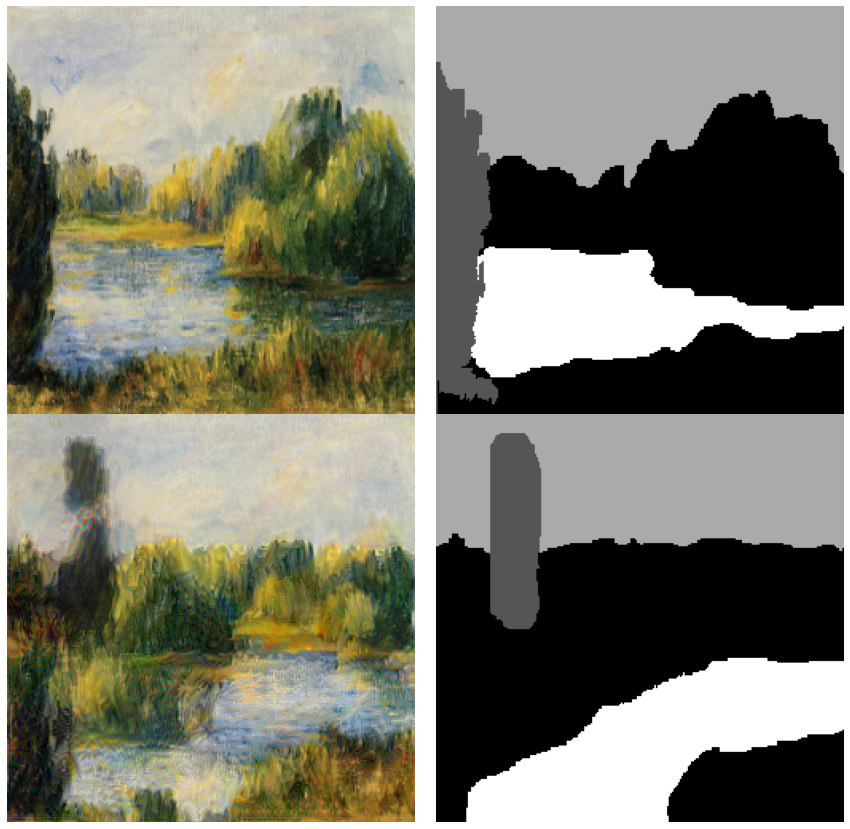

In [11]:
tag_layers = [
              tf.identity,
              tf.identity,
              tf.keras.layers.MaxPool2D(),
              tf.identity,
              tf.keras.layers.MaxPool2D(),
              tf.identity,
              tf.identity,
              tf.identity,
              tf.keras.layers.MaxPool2D(),
              tf.identity,
              tf.identity,
              tf.identity,
              tf.keras.layers.MaxPool2D(),
              tf.identity
]

# VGG layers used for the loss
layers = ['block1_conv1',
          'block1_conv2',
          'block2_conv1',
          'block2_conv2',
          'block3_conv1', 
          'block3_conv2',
          'block3_conv3',
          'block3_conv4',
          'block4_conv1', 
          'block4_conv2',
          'block4_conv3',
          'block4_conv4',
          'block5_conv1',
          'block5_conv2'
          ]


texture1np = decoders.decode_image_spatial_tag("./SpatialTags/Image1.png",size=256,method='bilinear').numpy()
tag1np = decoders.decode_image_spatial_tag("./SpatialTags/Tag1.png",size=256,channels=1,method='nearest').numpy()*255
texture2np = decoders.decode_image_spatial_tag("./SpatialTags/Image2.png",size=256,method='bilinear').numpy()
tag2np = decoders.decode_image_spatial_tag("./SpatialTags/Tag2.png",size=256,channels=1,method='nearest').numpy()*255

num_classes = len(np.unique(tag1np))
class_map = np.linspace(-10, 10, num_classes)

for idx, val in enumerate(np.unique(tag1np)):
  tag1np[tag1np==val] = class_map[idx]

for idx, val in enumerate(np.unique(tag2np)):
  tag2np[tag2np==val] = class_map[idx]

texture1 = tf.image.convert_image_dtype(texture1np, tf.float32)


extractor_tag = ExtractorVggModelSpatialTags(layers, tag_layers)
image, loss_slices = fit_slice_spatialtag(20, texture1, tag1np, tag2np, extractor_tag)

fig ,axes = plt.subplots(2, 2,figsize=(15,15))
axes[0,0].imshow(texture1np[0,:,:,:])
axes[0,1].imshow(tag1np[0,:,:,0],cmap="gray")
axes[1,0].imshow(image[0,:,:,:])
axes[1,1].imshow(tag2np[0,:,:,0],cmap="gray")
axes[0,0].axis('off')
axes[1,0].axis('off')
axes[0,1].axis('off')
axes[1,1].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)
